<a href="https://colab.research.google.com/github/AyishaR/Spokendigit/blob/master/Spokendigit_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torchvision
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
import tarfile
import os
import librosa
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import matplotlib
import csv
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

#Data

In [2]:
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Mel dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
class SpokenDigit(Dataset):
    def __init__(self, file = None, rootdir = None, transform = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        ik = self.rootdir+fname[:-4]+'.jpg'
        img = Image.open(ik)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(digit.index(label))
    
    def getsr(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+fname)
        return sr

Spoken_digit.csv genearted in 'Spokendigit feature extraction.ipynb'.

In [7]:
meldset = SpokenDigit('Spoken_digit.csv', '/content/drive/My Drive/Dataset/spokendigit/', transforms.Compose([transforms.ToTensor()]))

In [8]:
size = len(meldset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(meldset, [train_size, val_size])

train_size, val_size

(21300, 2366)

In [9]:
train_dl = DataLoader(train_dset, 64, True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_dset, 64, num_workers=6, pin_memory=True)

#device


In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#test_dl = DeviceDataLoader(test_dl, device)

#Train

In [13]:
class SpokenDigitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [14]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()
        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)         
    return history

In [23]:
model = to_device(SpokenDigitModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.09851787239313126, 'loss': 2.3029427528381348}

In [ ]:
torch.cuda.empty_cache()

In [24]:
history.append(fit(model, train_dl, val_dl, 128, 0.001))

Epoch  0



Last lr:  4.159611188916403e-05  Train_loss:  2.3022029399871826  Val_loss:  2.2982521057128906  Accuracy:  0.13480819761753082
Epoch  1



Last lr:  4.6393002654010734e-05  Train_loss:  2.2499301433563232  Val_loss:  2.2133281230926514  Accuracy:  0.16480492055416107
Epoch  2



Last lr:  5.435859286315734e-05  Train_loss:  2.19309139251709  Val_loss:  2.149871826171875  Accuracy:  0.2332579642534256
Epoch  3



Last lr:  6.54395881999855e-05  Train_loss:  2.080734968185425  Val_loss:  2.0245001316070557  Accuracy:  0.2958124577999115
Epoch  4



Last lr:  7.956185052050051e-05  Train_loss:  2.0067403316497803  Val_loss:  1.989564061164856  Accuracy:  0.3136306703090668
Epoch  5



Last lr:  9.663089387956672e-05  Train_loss:  1.9554660320281982  Val_loss:  1.9294567108154297  Accuracy:  0.36425185203552246
Epoch  6



Last lr:  0.00011653251669547203  Train_loss:  1.9064295291900635  Val_loss:  1.8847072124481201  Accuracy:  0.40521469712257385
Epoch  7



Last lr:  0.00013913356582328671  Train_loss:  1.8549895286560059  Val_loss:  1.808887004852295  Accuracy:  0.5236895084381104
Epoch  8



Last lr:  0.00016428282742492726  Train_loss:  1.7954285144805908  Val_loss:  1.805388331413269  Accuracy:  0.5345602631568909
Epoch  9



Last lr:  0.00019181203867550255  Train_loss:  1.7777634859085083  Val_loss:  1.7599987983703613  Accuracy:  0.6010380387306213
Epoch  10



Last lr:  0.00022153701353705153  Train_loss:  1.7364245653152466  Val_loss:  1.769805669784546  Accuracy:  0.617412269115448
Epoch  11



Last lr:  0.0002532588750676089  Train_loss:  1.7229636907577515  Val_loss:  1.7102527618408203  Accuracy:  0.6410881876945496
Epoch  12



Last lr:  0.0002867653860207501  Train_loss:  1.691282033920288  Val_loss:  1.6996954679489136  Accuracy:  0.7053318619728088
Epoch  13



Last lr:  0.00032183236883315237  Train_loss:  1.6758496761322021  Val_loss:  1.6669880151748657  Accuracy:  0.7454909682273865
Epoch  14



Last lr:  0.0003582252054996479  Train_loss:  1.663751482963562  Val_loss:  1.6567240953445435  Accuracy:  0.7674776315689087
Epoch  15



Last lr:  0.000395700407300754  Train_loss:  1.643613576889038  Val_loss:  1.6605429649353027  Accuracy:  0.7341979146003723
Epoch  16



Last lr:  0.0004340072438803157  Train_loss:  1.625705361366272  Val_loss:  1.600693702697754  Accuracy:  0.8313807845115662
Epoch  17



Last lr:  0.00047288942077380284  Train_loss:  1.6062177419662476  Val_loss:  1.5894049406051636  Accuracy:  0.8377152681350708
Epoch  18



Last lr:  0.000512086794163649  Train_loss:  1.5852071046829224  Val_loss:  1.5733706951141357  Accuracy:  0.8664723038673401
Epoch  19



Last lr:  0.0005513371113889472  Train_loss:  1.5691664218902588  Val_loss:  1.5588352680206299  Accuracy:  0.8833777904510498
Epoch  20



Last lr:  0.0005903777655645004  Train_loss:  1.5596858263015747  Val_loss:  1.5655187368392944  Accuracy:  0.8749046325683594
Epoch  21



Last lr:  0.0006289475525698362  Train_loss:  1.551138162612915  Val_loss:  1.5760631561279297  Accuracy:  0.8580127358436584
Epoch  22



Last lr:  0.0006667884186529299  Train_loss:  1.5447587966918945  Val_loss:  1.5480488538742065  Accuracy:  0.8934720754623413
Epoch  23



Last lr:  0.0007036471869561729  Train_loss:  1.5360298156738281  Val_loss:  1.5333856344223022  Accuracy:  0.9142054915428162
Epoch  24



Last lr:  0.0007392772514131546  Train_loss:  1.529991626739502  Val_loss:  1.5595470666885376  Accuracy:  0.8753133416175842
Epoch  25



Last lr:  0.0007734402266831224  Train_loss:  1.520715594291687  Val_loss:  1.5368189811706543  Accuracy:  0.9057731628417969
Epoch  26



Last lr:  0.0008059075430841241  Train_loss:  1.5221668481826782  Val_loss:  1.5233720541000366  Accuracy:  0.9281004667282104
Epoch  27



Last lr:  0.0008364619758538269  Train_loss:  1.5192965269088745  Val_loss:  1.5167217254638672  Accuracy:  0.9319555759429932
Epoch  28



Last lr:  0.0008648990985063872  Train_loss:  1.5123478174209595  Val_loss:  1.5135701894760132  Accuracy:  0.9403743147850037
Epoch  29



Last lr:  0.0008910286505615934  Train_loss:  1.506683349609375  Val_loss:  1.5303528308868408  Accuracy:  0.9217932224273682
Epoch  30



Last lr:  0.0009146758104953948  Train_loss:  1.5100873708724976  Val_loss:  1.5241024494171143  Accuracy:  0.9218068718910217
Epoch  31



Last lr:  0.0009356823653950571  Train_loss:  1.5078372955322266  Val_loss:  1.5140581130981445  Accuracy:  0.9315060973167419
Epoch  32



Last lr:  0.0009539077694932871  Train_loss:  1.5061590671539307  Val_loss:  1.5149017572402954  Accuracy:  0.9391210675239563
Epoch  33



Last lr:  0.0009692300844991355  Train_loss:  1.5026236772537231  Val_loss:  1.5005168914794922  Accuracy:  0.9556042551994324
Epoch  34



Last lr:  0.0009815467954343259  Train_loss:  1.5025708675384521  Val_loss:  1.5025542974472046  Accuracy:  0.9496784806251526
Epoch  35



Last lr:  0.0009907754965166069  Train_loss:  1.5051991939544678  Val_loss:  1.5314016342163086  Accuracy:  0.8905296325683594
Epoch  36



Last lr:  0.0009968544425011767  Train_loss:  1.5001658201217651  Val_loss:  1.5058337450027466  Accuracy:  0.9496784806251526
Epoch  37



Last lr:  0.0009997429617913927  Train_loss:  1.5019251108169556  Val_loss:  1.513454794883728  Accuracy:  0.9349116683006287
Epoch  38



Last lr:  0.0009998893609390691  Train_loss:  1.5059148073196411  Val_loss:  1.5940085649490356  Accuracy:  0.833015501499176
Epoch  39



Last lr:  0.0009992134106552783  Train_loss:  1.513425350189209  Val_loss:  1.5155144929885864  Accuracy:  0.9332224726676941
Epoch  40



Last lr:  0.0009979238061351152  Train_loss:  1.5024229288101196  Val_loss:  1.5130131244659424  Accuracy:  0.9345030784606934
Epoch  41



Last lr:  0.0009960221326213456  Train_loss:  1.500379204750061  Val_loss:  1.5295612812042236  Accuracy:  0.9146277904510498
Epoch  42



Last lr:  0.00099351072774084  Train_loss:  1.5056902170181274  Val_loss:  1.5198428630828857  Accuracy:  0.9277054071426392
Epoch  43



Last lr:  0.0009903926786310544  Train_loss:  1.5138554573059082  Val_loss:  1.5211538076400757  Accuracy:  0.9281412959098816
Epoch  44



Last lr:  0.0009866718181451742  Train_loss:  1.5005817413330078  Val_loss:  1.5122966766357422  Accuracy:  0.9361513257026672
Epoch  45



Last lr:  0.0009823527201405897  Train_loss:  1.5091643333435059  Val_loss:  1.5289621353149414  Accuracy:  0.8723980784416199
Epoch  46



Last lr:  0.000977440693856496  Train_loss:  1.500205636024475  Val_loss:  1.5091826915740967  Accuracy:  0.9357699751853943
Epoch  47



Last lr:  0.0009719417773875231  Train_loss:  1.500823974609375  Val_loss:  1.549371600151062  Accuracy:  0.901931643486023
Epoch  48



Last lr:  0.0009658627302614283  Train_loss:  1.5859019756317139  Val_loss:  1.52765953540802  Accuracy:  0.9091243147850037
Epoch  49



Last lr:  0.0009592110251299625  Train_loss:  1.5102421045303345  Val_loss:  1.5157124996185303  Accuracy:  0.9239319562911987
Epoch  50



Last lr:  0.0009519948385831354  Train_loss:  1.5015190839767456  Val_loss:  1.5079529285430908  Accuracy:  0.9437662959098816
Epoch  51



Last lr:  0.000944223041098164  Train_loss:  1.4989879131317139  Val_loss:  1.5232698917388916  Accuracy:  0.9175702929496765
Epoch  52



Last lr:  0.0009359051861354648  Train_loss:  1.5017006397247314  Val_loss:  1.5426814556121826  Accuracy:  0.8748092651367188
Epoch  53



Last lr:  0.0009270514983950872  Train_loss:  1.5145318508148193  Val_loss:  1.5095031261444092  Accuracy:  0.9319555759429932
Epoch  54



Last lr:  0.000917672861248031  Train_loss:  1.5148417949676514  Val_loss:  1.5154829025268555  Accuracy:  0.9133473038673401
Epoch  55



Last lr:  0.0009077808033578921  Train_loss:  1.5067520141601562  Val_loss:  1.5003117322921753  Accuracy:  0.9509181380271912
Epoch  56



Last lr:  0.000897387484509285  Train_loss:  1.5125154256820679  Val_loss:  1.5242887735366821  Accuracy:  0.8968504667282104
Epoch  57



Last lr:  0.0008865056806604616  Train_loss:  1.5017330646514893  Val_loss:  1.5253076553344727  Accuracy:  0.9243542551994324
Epoch  58



Last lr:  0.0008751487682385003  Train_loss:  1.528066873550415  Val_loss:  1.5198980569839478  Accuracy:  0.9260162115097046
Epoch  59



Last lr:  0.0008633307076963694  Train_loss:  1.5081517696380615  Val_loss:  1.511338710784912  Accuracy:  0.9268472194671631
Epoch  60



Last lr:  0.0008510660263520802  Train_loss:  1.5313332080841064  Val_loss:  1.562307596206665  Accuracy:  0.8081680536270142
Epoch  61



Last lr:  0.000838369800531021  Train_loss:  1.5884747505187988  Val_loss:  1.5654280185699463  Accuracy:  0.8731881976127625
Epoch  62



Last lr:  0.0008252576370334268  Train_loss:  1.5479789972305298  Val_loss:  1.563887357711792  Accuracy:  0.7777217626571655
Epoch  63



Last lr:  0.000811745653949763  Train_loss:  1.5174294710159302  Val_loss:  1.5196621417999268  Accuracy:  0.8981446027755737
Epoch  64



Last lr:  0.0007978504608476077  Train_loss:  1.5311200618743896  Val_loss:  1.535285234451294  Accuracy:  0.8998337984085083
Epoch  65



Last lr:  0.000783589138354387  Train_loss:  1.529234528541565  Val_loss:  1.5313221216201782  Accuracy:  0.8951749205589294
Epoch  66



Last lr:  0.0007689792171610618  Train_loss:  1.5150585174560547  Val_loss:  1.5120470523834229  Accuracy:  0.9306750893592834
Epoch  67



Last lr:  0.0007540386564725742  Train_loss:  1.4977788925170898  Val_loss:  1.527312159538269  Accuracy:  0.9348980784416199
Epoch  68



Last lr:  0.0007387858219315447  Train_loss:  1.5090855360031128  Val_loss:  1.5866907835006714  Accuracy:  0.825032651424408
Epoch  69



Last lr:  0.0007232394630423574  Train_loss:  1.5426959991455078  Val_loss:  1.524935007095337  Accuracy:  0.8981581926345825
Epoch  70



Last lr:  0.0007074186901233847  Train_loss:  1.5190941095352173  Val_loss:  1.5113272666931152  Accuracy:  0.9424722194671631
Epoch  71



Last lr:  0.0006913429508156802  Train_loss:  1.5092724561691284  Val_loss:  1.5177749395370483  Accuracy:  0.9348708391189575
Epoch  72



Last lr:  0.0006750320061770209  Train_loss:  1.5360835790634155  Val_loss:  1.5231068134307861  Accuracy:  0.9108407497406006
Epoch  73



Last lr:  0.0006585059063906824  Train_loss:  1.5202069282531738  Val_loss:  1.514904499053955  Accuracy:  0.9146277904510498
Epoch  74



Last lr:  0.0006417849661188058  Train_loss:  1.5227833986282349  Val_loss:  1.5345691442489624  Accuracy:  0.9052827954292297
Epoch  75



Last lr:  0.0006248897395306571  Train_loss:  1.51076340675354  Val_loss:  1.5645902156829834  Accuracy:  0.8563099503517151
Epoch  76



Last lr:  0.0006078409950364705  Train_loss:  1.5165995359420776  Val_loss:  1.5063579082489014  Accuracy:  0.9370095729827881
Epoch  77



Last lr:  0.0005906596897579396  Train_loss:  1.5041093826293945  Val_loss:  1.5121203660964966  Accuracy:  0.9192458391189575
Epoch  78



Last lr:  0.0005733669437667318  Train_loss:  1.5094153881072998  Val_loss:  1.5286734104156494  Accuracy:  0.9348980784416199
Epoch  79



Last lr:  0.0005559840141227016  Train_loss:  1.5232102870941162  Val_loss:  1.5047482252120972  Accuracy:  0.9471446871757507
Epoch  80



Last lr:  0.0005385322687437066  Train_loss:  1.5102289915084839  Val_loss:  1.505821943283081  Accuracy:  0.9365872740745544
Epoch  81



Last lr:  0.0005210331601391555  Train_loss:  1.5076987743377686  Val_loss:  1.5309956073760986  Accuracy:  0.8833505511283875
Epoch  82



Last lr:  0.0005035081990395695  Train_loss:  1.5138384103775024  Val_loss:  1.5577616691589355  Accuracy:  0.8744823336601257
Epoch  83



Last lr:  0.0004859789279545781  Train_loss:  1.5124967098236084  Val_loss:  1.508039951324463  Accuracy:  0.9458777904510498
Epoch  84



Last lr:  0.00046846689469184785  Train_loss:  1.5004043579101562  Val_loss:  1.5563080310821533  Accuracy:  0.8634889721870422
Epoch  85



Last lr:  0.00045099362586950033  Train_loss:  1.5111913681030273  Val_loss:  1.5315234661102295  Accuracy:  0.918006181716919
Epoch  86



Last lr:  0.00043358060045457704  Train_loss:  1.513482928276062  Val_loss:  1.55856192111969  Accuracy:  0.8178672790527344
Epoch  87



Last lr:  0.00041624922336007847  Train_loss:  1.519162893295288  Val_loss:  1.5266674757003784  Accuracy:  0.9099961519241333
Epoch  88



Last lr:  0.00039902079913303425  Train_loss:  1.5081160068511963  Val_loss:  1.5088304281234741  Accuracy:  0.9353203773498535
Epoch  89



Last lr:  0.00038191650576594913  Train_loss:  1.4999438524246216  Val_loss:  1.506805181503296  Accuracy:  0.9454554915428162
Epoch  90



Last lr:  0.0003649573686638133  Train_loss:  1.4960782527923584  Val_loss:  1.503827452659607  Accuracy:  0.9458777904510498
Epoch  91



Last lr:  0.00034816423479868287  Train_loss:  1.5092964172363281  Val_loss:  1.513965368270874  Accuracy:  0.9348844289779663
Epoch  92



Last lr:  0.00033155774708359677  Train_loss:  1.4971923828125  Val_loss:  1.5141628980636597  Accuracy:  0.9247493147850037
Epoch  93



Last lr:  0.00031515831899733403  Train_loss:  1.4997265338897705  Val_loss:  1.5069457292556763  Accuracy:  0.9298304915428162
Epoch  94



Last lr:  0.0002989861094912015  Train_loss:  1.5053664445877075  Val_loss:  1.505842685699463  Accuracy:  0.9395161271095276
Epoch  95



Last lr:  0.0002830609982086992  Train_loss:  1.4955848455429077  Val_loss:  1.507158637046814  Accuracy:  0.9281277060508728
Epoch  96



Last lr:  0.0002674025610485235  Train_loss:  1.4958631992340088  Val_loss:  1.498714566230774  Accuracy:  0.9572798013687134
Epoch  97



Last lr:  0.0002520300461009492  Train_loss:  1.4913780689239502  Val_loss:  1.5024778842926025  Accuracy:  0.9424993991851807
Epoch  98



Last lr:  0.00023696234998716714  Train_loss:  1.4924826622009277  Val_loss:  1.5016729831695557  Accuracy:  0.950114369392395
Epoch  99



Last lr:  0.00022221799463066505  Train_loss:  1.4955410957336426  Val_loss:  1.499097466468811  Accuracy:  0.9488474726676941
Epoch  100



Last lr:  0.00020781510448920573  Train_loss:  1.4889835119247437  Val_loss:  1.4999620914459229  Accuracy:  0.9513676762580872
Epoch  101



Last lr:  0.00019377138427538755  Train_loss:  1.488633394241333  Val_loss:  1.504465103149414  Accuracy:  0.9378677606582642
Epoch  102



Last lr:  0.00018010409719317497  Train_loss:  1.490389108657837  Val_loss:  1.4985464811325073  Accuracy:  0.9530841708183289
Epoch  103



Last lr:  0.00016683004371715395  Train_loss:  1.4908208847045898  Val_loss:  1.5027027130126953  Accuracy:  0.9547460675239563
Epoch  104



Last lr:  0.00015396554094059488  Train_loss:  1.4899566173553467  Val_loss:  1.4974998235702515  Accuracy:  0.958968997001648
Epoch  105



Last lr:  0.00014152640251771198  Train_loss:  1.489984154701233  Val_loss:  1.4960004091262817  Accuracy:  0.9488474726676941
Epoch  106



Last lr:  0.00012952791922477127  Train_loss:  1.4871889352798462  Val_loss:  1.4948384761810303  Accuracy:  0.9517899751663208
Epoch  107



Last lr:  0.0001179848401639479  Train_loss:  1.4878995418548584  Val_loss:  1.4960887432098389  Accuracy:  0.9522258639335632
Epoch  108



Last lr:  0.00010691135463303314  Train_loss:  1.4866362810134888  Val_loss:  1.4967989921569824  Accuracy:  0.9551683664321899
Epoch  109



Last lr:  9.632107468327899e-05  Train_loss:  1.4877049922943115  Val_loss:  1.495846152305603  Accuracy:  0.9526345729827881
Epoch  110



Last lr:  8.622701838682239e-05  Train_loss:  1.4858999252319336  Val_loss:  1.4952561855316162  Accuracy:  0.9488338828086853
Epoch  111



Last lr:  7.664159383425639e-05  Train_loss:  1.4852944612503052  Val_loss:  1.4954609870910645  Accuracy:  0.9534791707992554
Epoch  112



Last lr:  6.75765838820193e-05  Train_loss:  1.4873908758163452  Val_loss:  1.4993358850479126  Accuracy:  0.9471582770347595
Epoch  113



Last lr:  5.904313166835123e-05  Train_loss:  1.4878729581832886  Val_loss:  1.495880126953125  Accuracy:  0.9509589672088623
Epoch  114



Last lr:  5.105172691562225e-05  Train_loss:  1.4865127801895142  Val_loss:  1.4940180778503418  Accuracy:  0.9509589672088623
Epoch  115



Last lr:  4.361219303587067e-05  Train_loss:  1.4856820106506348  Val_loss:  1.4936400651931763  Accuracy:  0.9526345729827881
Epoch  116



Last lr:  3.673367505540104e-05  Train_loss:  1.484818696975708  Val_loss:  1.4948233366012573  Accuracy:  0.9530568718910217
Epoch  117



Last lr:  3.0424628373285855e-05  Train_loss:  1.4846004247665405  Val_loss:  1.4943615198135376  Accuracy:  0.9534791707992554
Epoch  118



Last lr:  2.4692808367590144e-05  Train_loss:  1.4842159748077393  Val_loss:  1.4937593936920166  Accuracy:  0.9555906057357788
Epoch  119



Last lr:  1.9545260862094143e-05  Train_loss:  1.4838855266571045  Val_loss:  1.4932746887207031  Accuracy:  0.9564352035522461
Epoch  120



Last lr:  1.4988313465234402e-05  Train_loss:  1.4836171865463257  Val_loss:  1.4937201738357544  Accuracy:  0.9572798013687134
Epoch  121



Last lr:  1.1027567791908654e-05  Train_loss:  1.4835320711135864  Val_loss:  1.493293046951294  Accuracy:  0.957702100276947
Epoch  122



Last lr:  7.667892577705994e-06  Train_loss:  1.4836952686309814  Val_loss:  1.4931421279907227  Accuracy:  0.9572798013687134
Epoch  123



Last lr:  4.913417694027851e-06  Train_loss:  1.4834768772125244  Val_loss:  1.492634654045105  Accuracy:  0.9581243991851807
Epoch  124



Last lr:  2.7675290714544136e-06  Train_loss:  1.4833366870880127  Val_loss:  1.492605209350586  Accuracy:  0.9581243991851807
Epoch  125



Last lr:  1.2328645375991738e-06  Train_loss:  1.483319878578186  Val_loss:  1.4925988912582397  Accuracy:  0.9581243991851807
Epoch  126



Last lr:  3.1131057456677687e-07  Train_loss:  1.4832597970962524  Val_loss:  1.492598295211792  Accuracy:  0.9581243991851807
Epoch  127



Last lr:  4e-09  Train_loss:  1.4832593202590942  Val_loss:  1.492598056793213  Accuracy:  0.9581243991851807


In [25]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [26]:
torch.save(model, '/content/spokendigit_cnn_mel.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SpokenDigitModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  1.492598056793213 
Accuracy:  0.9581243991851807 
F-score:  0.9573119188503804


In [28]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

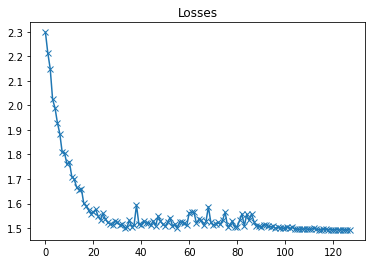

In [29]:
plot(losses, 'Losses')

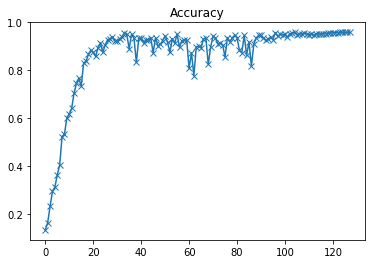

In [30]:
plot(accuracies, 'Accuracy')

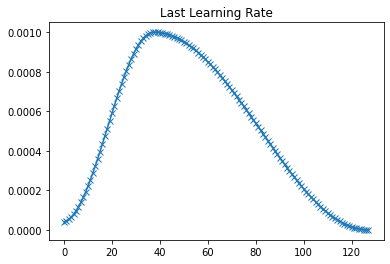

In [31]:
plot(last_lr, 'Last Learning Rate')